In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
#train_data.head()
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Explore Data:

0    4342
1    3271
Name: target, dtype: int64


Text(0.5, 0, 'X-Axiz')

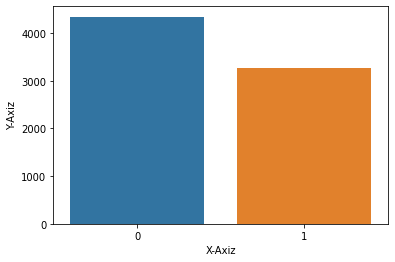

In [4]:
train_data[train_data['target']==1].values[1]
x = train_data.target.value_counts()
print(x)
sns.barplot(x.index,x)
plt.gca().set_ylabel('Y-Axiz')
plt.gca().set_xlabel('X-Axiz')

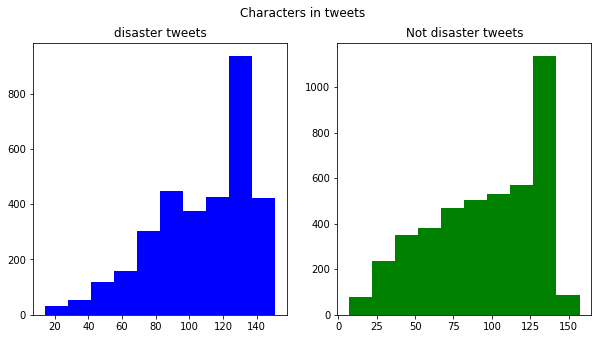

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Data Cleaning:

In [6]:
#Text Preporcessing
#Convert LowerCase:
train_data["text_clean"] = train_data["text"].apply(lambda x: x.lower())
test_data["text_clean"] = test_data["text"].apply(lambda x: x.lower())

#Special Characters Removal:
train_data['text_clean']= train_data['text_clean'].str.replace('rt ',"").str.replace('@','').str.replace('#','').str.replace('[^\w\s]','').str.replace('[1-9]','')
test_data['text_clean']= test_data['text_clean'].str.replace('rt ',"").str.replace('@','').str.replace('#','').str.replace('[^\w\s]','').str.replace('[1-9]','')
# Remove URL
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_URL(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_URL(x))

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_html(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_html(x))

def remove_emojis(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_emojis(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_emojis(x))

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))


train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_punct(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_punct(x))

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

train_data["text_clean"] = train_data["text_clean"].apply(lambda x: remove_non_ascii(x))
test_data["text_clean"] = test_data["text_clean"].apply(lambda x: remove_non_ascii(x))
print(train_data["text_clean"])
print(test_data["text_clean"])




0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       000 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610      m 00 utckm s of volcano hawaii httptcozdtoydebj
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text_clean, Length: 7613, dtype: object
0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4             typhoon soudelor kills  in china and taiwan
                          

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

train_data['text'] = train_data['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
test_data['text'] = train_data['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))






[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
#Filling missing values
train_data.isnull().sum()
test_data.isnull().sum()
train_data['location'] = train_data['location'].fillna('None')
train_data['keyword'] = train_data['keyword'].fillna('None')
test_data['location'] = test_data['location'].fillna('None')
test_data['keyword'] = test_data['keyword'].fillna('None')

In [9]:
train_data.head()


# Dropping Un-necessary features:
#train_data = train_data.drop('id', axis=1)
train_data.drop(columns=['id'])
test_data.drop(columns=['id'])
#test_data = test_data.drop('id', axis=1)



,keyword,location,text,text_clean
0,None,None,Our Deeds Reason #earthquake May ALLAH Forgive us,just happened a terrible car crash
1,None,None,Forest fire near La Ronge Sask. Canada,heard about earthquake is different cities sta...
2,None,None,All residents asked 'shelter place' notified o...,there is a forest fire at spot pond geese are ...
3,None,None,"13,000 people receive #wildfires evacuation or...",apocalypse lighting spokane wildfires
4,None,None,Just got sent photo Ruby #Alaska smoke #wildfi...,typhoon soudelor kills in china and taiwan
...,...,...,...,...
3258,None,None,Do feel engulfed low self-image? Take quiz: ht...,earthquake safety los angeles safety fastener...
3259,None,None,Man equally incapable seeing nothingness emerg...,storm in ri worse than last hurricane my citya...
3260,None,None,Fully Engulfed Garage Fire: Propane Tanks Insi...,green line derailment in chicago httptcoutbxlc...
3261,None,None,He came land engulfed tribal war turned land p...,meg issues hazardous weather outlook hwo httpt...


In [10]:
# Tokenization
import nltk
from nltk import TweetTokenizer

tokenizer = TweetTokenizer()

train_data['tokens'] = [tokenizer.tokenize(item) for item in train_data.text]
test_data['tokens'] = [ tokenizer.tokenize(item) for item in test_data.text]
print(train_data['tokens'])
print(test_data['tokens'])



0       [Our, Deeds, Reason, #earthquake, May, ALLAH, ...
1        [Forest, fire, near, La, Ronge, Sask, ., Canada]
2       [All, residents, asked, ', shelter, place, ', ...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, photo, Ruby, #Alaska, smoke,...
                              ...                        
7608    [Two, giant, cranes, holding, bridge, collapse...
7609    [@aria_ahrary, @TheTawniest, The, control, wil...
7610    [M1, ., 94, [, 01:04, UTC, ], ?, 5km, S, Volca...
7611    [Police, investigating, e-bike, collided, car,...
7612    [The, Latest, :, More, Homes, Razed, Northern,...
Name: tokens, Length: 7613, dtype: object
0       [Our, Deeds, Reason, #earthquake, May, ALLAH, ...
1        [Forest, fire, near, La, Ronge, Sask, ., Canada]
2       [All, residents, asked, ', shelter, place, ', ...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, photo, Ruby, #Alaska, smoke,...
                              

In [11]:
# Lemmatization

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_item(item):
    new_item = []
    for x in item:
        x = lemmatizer.lemmatize(x)
        new_item.append(x)
    return " ".join(new_item)

train_data['tokens'] = [lemmatize_item(item) for item in train_data.tokens]
test_data['tokens'] = [lemmatize_item(item) for item in test_data.tokens]
print(train_data['tokens'])

0        Our Deeds Reason #earthquake May ALLAH Forgive u
1                 Forest fire near La Ronge Sask . Canada
2       All resident asked ' shelter place ' notified ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent photo Ruby #Alaska smoke #wildfi...
                              ...                        
7608    Two giant crane holding bridge collapse nearby...
7609    @aria_ahrary @TheTawniest The control wild fir...
7610    M1 . 94 [ 01:04 UTC ] ? 5km S Volcano Hawaii ....
7611    Police investigating e-bike collided car Littl...
7612    The Latest : More Homes Razed Northern Califor...
Name: tokens, Length: 7613, dtype: object


In [12]:
# Vectorization

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()


X = vectorizer.fit_transform(train_data.text).toarray()
y = train_data['target']

In [13]:
#Data Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [14]:
#Applying Model
# LOGISTIC REGRESSION
"""
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model 
log = LogisticRegression(random_state = 0)

# Fitting data
log.fit(X_train, y_train)

# Predicting the data
log_pred = log.predict(X_test)

"""

'\nfrom sklearn.linear_model import LogisticRegression\n\n# Logistic Regression Model \nlog = LogisticRegression(random_state = 0)\n\n# Fitting data\nlog.fit(X_train, y_train)\n\n# Predicting the data\nlog_pred = log.predict(X_test)\n\n'

In [15]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
log = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
log.fit(X_train,y_train)

log_pred=log.predict(X_test)

In [16]:
"""
from sklearn.ensemble import AdaBoostClassifier

log = AdaBoostClassifier()
log.fit(X_train,y_train)

log_pred=log.predict(X_test)
"""

'\nfrom sklearn.ensemble import AdaBoostClassifier\n\nlog = AdaBoostClassifier()\nlog.fit(X_train,y_train)\n\nlog_pred=log.predict(X_test)\n'

In [17]:
# MODEL EVALUATION FOR LOGISTIC REGRESSION

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score,KFold

# Accuracy
acc = accuracy_score(y_test,log_pred)
print("\nACCURACY : ",acc)




ACCURACY :  0.8010505581089954


In [18]:
# KFold Cross Validation
kfold = KFold(n_splits=15)
results = cross_val_score(log, X, y,cv=kfold)
print("\nK-FOLD CROSS VALIDATION : ",results.mean())




K-FOLD CROSS VALIDATION :  0.7246796813120253


In [19]:
# Classification Report
clf_report = classification_report(y_test,log_pred)
print("\nCLASSIFICATION REPORT:\n", clf_report)




CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.77      0.93      0.85       886
           1       0.87      0.62      0.72       637

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523




CONFUSION MATRIX:


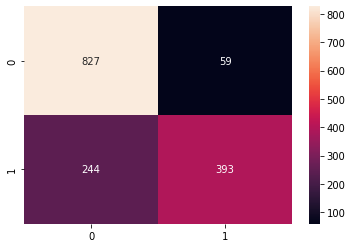

In [20]:
# Confusion Matrix
print("\nCONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='g')
plt.show()


In [21]:
test = vectorizer.transform(test_data.text).toarray()
pred = log.predict(test)
submission_df = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submission_df['target'] = pred
submission_df.to_csv('submission.csv', index=False)
result = pd.read_csv('submission.csv')
print (result)
#result

         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       0
3259  10865       0
3260  10868       1
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]
